# Recurrent Neural Network


### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [1]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

In [2]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import spacy

nlp = spacy.load("en_core_web_sm")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Tue Nov 21 07:17:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P0              26W / 200W |   2537MiB / 12282MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [106]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, TextVectorization, Embedding, Bidirectional, Attention, GaussianNoise
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, SimpleRNNCell, StackedRNNCells, LSTMCell, GRUCell, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [6]:
import visualkeras

In [7]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [8]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [9]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [10]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


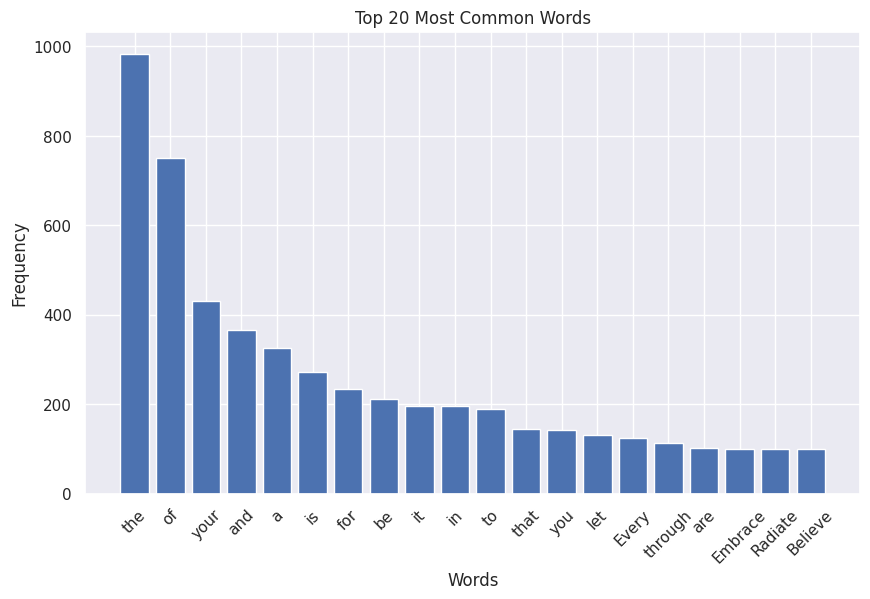

In [11]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [12]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [13]:
train, test = train_test_split(df["Quotes"], test_size=0.2, random_state=23)
train, validation = train_test_split(train, test_size=2/8, random_state=23)

In [14]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

def keep_joint(sentence, joiner):
    output = [sentence[0]]
    for i, word in enumerate(sentence[1:]):
        if joiner in word:
            output.pop()
            output.append(sentence[i-1]+word)
            print(i, sentence)
        else:
            output.append(word)
    return output

def remove_contractions(sentence):
    contractions = {
        "'s": "is",
        "'ve": "have",
        "'ll": "will"
    }
    output = []
    for word in sentence:
        if word in contractions:
            word = contractions[word]
        output.append(word)
    # print(output)
    return output

def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = remove_punctuation(sentence)
        # sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

def clean_sentences_for_input(sentences):
    # for i, sentence in enumerate(sentences):
    #     # sentences[i] = remove_punctuation(sentence)
    #     sentences[i] = remove_contractions(sentence)
    #     # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

In [15]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [16]:
all_words = []

for word in tokenized_quotes:
    all_words += word
    
print(f"Total word count: {len(all_words)}")

# for word in lemmatized_quotes:
#     all_words += word

all_words = list(set(all_words))

Total word count: 12205


In [17]:
for i in range(5):
    print(tokenized_quotes[i])

# for i in range(5):
#     print(lemmatized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=True)
tokenizer.fit_on_texts([all_words])

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

max_sequence_length = 35

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy']
['Embrace', 'challenges', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories']
['Embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul']
['Embrace', 'kindness', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time']
['Embrace', 'the', 'journey', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams']
Number of unique words: 1180


In [18]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [90]:
def sentences_to_data(sentences, min_len, segment, max_len=100, tokenize=True, verbose=0):
    # X_lemma = []
    X_word = []
    y = []

    tokenized_input = [[token.text for token in nlp(quote)] for quote in sentences]
    tokenized_input = clean_sentences(tokenized_input)
    
    # min_sequence_length = 4
    # max_sequence_length = 25
    if segment:
        for sequence in tokenized_input:
            for i in range(len(sequence)):
                for j in range(i+min_len, len(sequence) if len(sequence) < i+max_len else i+max_len):
                    # X_lemma.append(" ".join(sequence[i:j]))
                    X_word.append(" ".join(sequence[i:j]))
                    y.append(sequence[j])
                    if verbose > 0:
                        if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                            print(y[-1])
    else:
        for sequence in tokenized_input:
            for i in range(min_len, len(sequence) if len(sequence) < max_len else max_len):
                X_word.append(" ".join(sequence[:i]))
                y.append(sequence[i])
                if verbose > 0:
                    if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                        print(y[-1])

    sentence_lengths = [len(sentence.split(" ")) for sentence in sentences]
    if verbose > 0:
        print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
        print("Maximum sentence length:", max(sentence_lengths))
        print("Longest sentence: ", X_word[np.argmax(sentence_lengths)])
        print("Minimum sentence length:", min(sentence_lengths))

    if tokenize:
        X_word = tokenizer.texts_to_sequences(X_word)
        X_word = pad_sequences(X_word, maxlen=max_sequence_length, padding="pre")
    else:
        X_word = clean_sentences_for_input([sentence.split(" ") for sentence in X_word])
        X_word = [" ".join(sentence) for sentence in X_word]

    y = tokenizer.texts_to_sequences(y)
    
    if verbose > 0:
        for pred, label in zip(X_word[:5], y[:5]):
            print(f"Predictor: {pred}\nLabel: {label}")
    
    y = to_categorical(y, num_classes=total_words)
    y = y.astype(float)
    y = np.array(y)

    X_word = np.array(X_word)

    if verbose > 0:
        print(X_word.shape, y.shape)

    return X_word, y

In [137]:
def fit_model(model, filepath, batch_size=32, epochs=20, callbacks=[]):
    # cp_callback = ModelCheckpoint(filepath=filepath, save_format='tf', save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
    
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        callbacks=[] + callbacks
    )
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    print(f"Accuracy: {accuracy:.2f}")

    return history

def plot_history(fit_history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    left_legend = []
    for k, v in fit_history.items():
        ax[0].plot(v.history['accuracy'])
        ax[0].plot(v.history['val_accuracy'])
        left_legend += [f'{k} Train', f'{k} Validation']
    ax[0].legend(left_legend, loc='lower right')
    
    right_legend = []
    for k, v in fit_history.items():
        ax[1].plot(v.history['loss'])
        ax[1].plot(v.history['val_loss'])
        right_legend += [f'{k} Train', f'{k} Validation']
    ax[1].legend(right_legend, loc='upper right')
    
    plt.tight_layout()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')
    plt.show()

def predict_next_word(model, seed_text, next_words=1):
    for _ in range(next_words):
        seed_text = [token.text for token in nlp(seed_text)]
        seed_text = " ".join(clean_sentences_for_input(clean_sentences([seed_text]))[0])

        # print(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        model_prediction = model.predict([seed_text], verbose=0)
        predicted_index = np.argmax(model_prediction, axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
    return seed_text

def sample_with_temperature(probs, temperature=1.0):
    if temperature != 0:
        # Adjust probabilities with temperature
        probs = np.power(probs, 1.0 / temperature)
        probs /= np.sum(probs)

    # print(probs)
    # Sample a word
    sampled_index = np.random.choice(len(probs), p=probs)

    # print(sampled_index)
    return sampled_index

def predict_next_word_temperature(model, seed_text, temperature, next_words=1):
    for _ in range(next_words):
        seed_text = [token.text for token in nlp(seed_text)]
        seed_text = " ".join(clean_sentences_for_input(clean_sentences([seed_text]))[0])

        # print(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        model_prediction = model.predict([seed_text], verbose=0)

        # print(np.array(model_prediction).shape)
        predicted_index = [sample_with_temperature(x/sum(x), temperature) for x in model_prediction][0]

        
        # predicted_index = sample_with_temperature(model_prediction, temperature)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
    return seed_text


In [54]:
# # predict_next_word_temperature

# # for seed_text in seed_texts:
# #     predicted_text = predict_next_word(simple_GRU_B, seed_text, next_words=10)
# #     print(predicted_text)
# print("Temperature: 0")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 0, next_words=10)
#     print(predicted_text)

# print("Temperature: 1")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 1, next_words=10)
#     print(predicted_text)

### TextVectorization

In [22]:
random.seed(42)

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=1)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=1)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=1)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

Average sentence length: 11.971666666666666
Maximum sentence length: 35
Longest sentence:  classroom where we learn to cherish
Minimum sentence length: 7
Predictor: Embrace the
Label: [729]
Predictor: Embrace the magic
Label: [22]
Predictor: Embrace the magic in
Label: [19]
Predictor: Embrace the magic in the
Label: [857]
Predictor: Embrace the magic in the ordinary
Label: [400]
(38158,) (38158, 1181)
Average sentence length: 11.34
Maximum sentence length: 19
Longest sentence:  Believe in yourself
Minimum sentence length: 7
Predictor: Let your
Label: [888]
Predictor: Let your generosity
Label: [995]
Predictor: Let your generosity be
Label: [19]
Predictor: Let your generosity be the
Label: [725]
Predictor: Let your generosity be the ripple
Label: [976]
(1933,) (1933, 1181)
Average sentence length: 12.07
Maximum sentence length: 29
Longest sentence:  Radiate authenticity for it is the essence
Minimum sentence length: 7
Predictor: Radiate forgiveness
Label: [129]
Predictor: Radiate forgiv

In [23]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=40,
    # ngrams=5
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

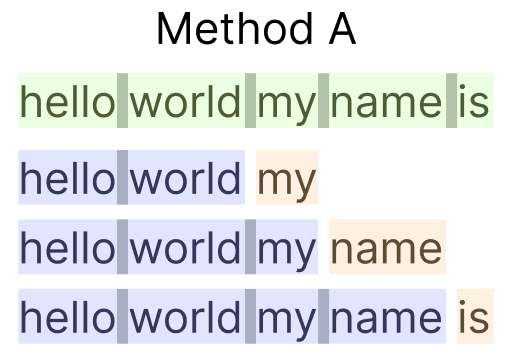

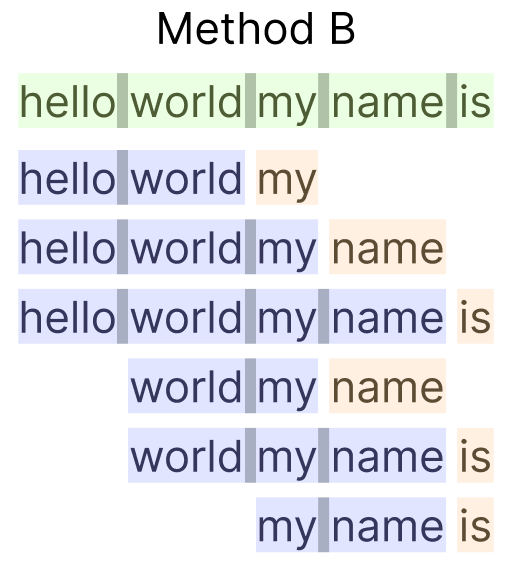

In [24]:
display(Image("images/Method A.png"))
display(Image("images/Method B.png"))

**Legend**
* Green is the original text
* Blue becomes the `X`
* Orange becomes the `y`

Method A is a more direct approach and mirrors the target task, where the predicted word is recursively added to the seed text. <br>
Method B extends this idea by creating the `X` starting from subsequent words in the original text. This creates much more data for the models to work with and I think this could help capture the word-to-word relationships better.

For both method A and B I will test and validate on method A, since that is reflective of the final word prediction task.

In [91]:
# Method A

simple_GRU_A = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_A.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

prepro_methods = {}

# min length 2
X_train, y_train = sentences_to_data(train, 2, False, tokenize=False, verbose=0)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=0)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

prepro_methods["A"] = fit_model(simple_GRU_A, "", batch_size=64, epochs=50)

# Method B

simple_GRU_B = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_B.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=0)
# X_test, y_test = sentences_to_data(test, 2, True, tokenize=False, verbose=0)
# X_validation, y_validation = sentences_to_data(validation, 2, True, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

simple_GRU_B.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
prepro_methods["B"] = fit_model(simple_GRU_B, "", batch_size=256, epochs=50)

Epoch 1/50
97/97 [==============================] - 7s 50ms/step - loss: 5.9334 - accuracy: 0.1036 - val_loss: 5.5072 - val_accuracy: 0.0895
Epoch 2/50
97/97 [==============================] - 2s 23ms/step - loss: 5.1182 - accuracy: 0.1442 - val_loss: 5.1496 - val_accuracy: 0.1535
Epoch 3/50
97/97 [==============================] - 2s 17ms/step - loss: 4.6263 - accuracy: 0.1887 - val_loss: 4.7725 - val_accuracy: 0.2218
Epoch 4/50
97/97 [==============================] - 1s 14ms/step - loss: 4.1415 - accuracy: 0.2725 - val_loss: 4.4507 - val_accuracy: 0.2772
Epoch 5/50
97/97 [==============================] - 1s 15ms/step - loss: 3.7515 - accuracy: 0.3332 - val_loss: 4.2338 - val_accuracy: 0.3186
Epoch 6/50
97/97 [==============================] - 1s 15ms/step - loss: 3.4518 - accuracy: 0.3817 - val_loss: 4.0832 - val_accuracy: 0.3412
Epoch 7/50
97/97 [==============================] - 2s 16ms/step - loss: 3.2119 - accuracy: 0.4081 - val_loss: 3.9860 - val_accuracy: 0.3527
Epoch 8/50
97

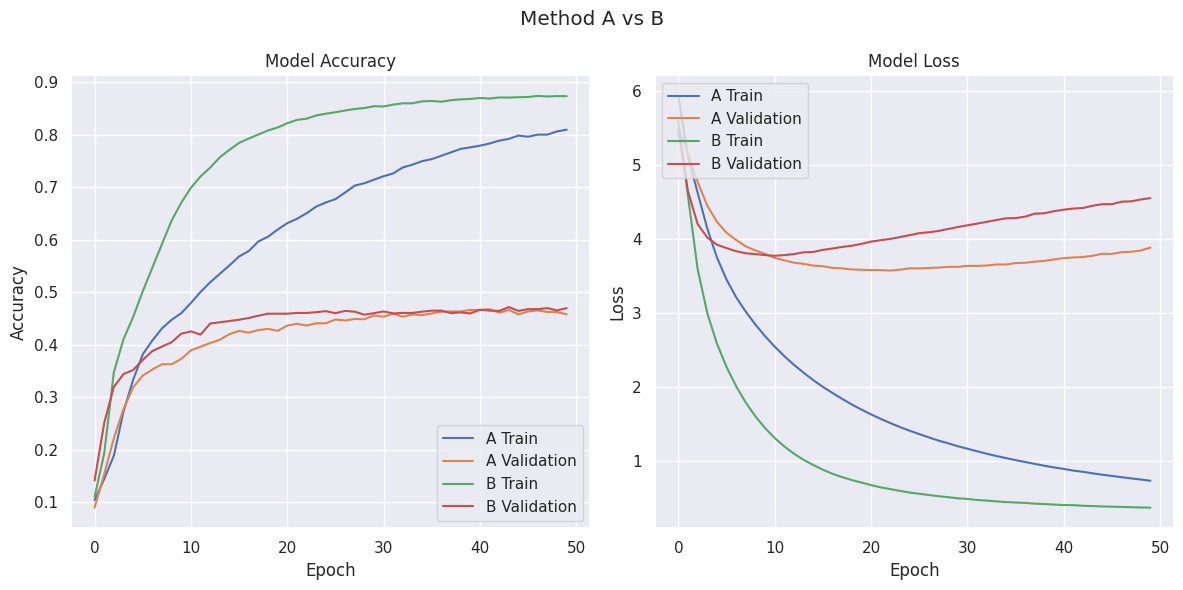

In [92]:
plot_history(prepro_methods, title="Method A vs B")

In [93]:
def eval_different_length_test(model, min_len=2, max_len=12):
    y = []
    for i in range(min_len, max_len+1):
    
        X_test, y_test = sentences_to_data(test, i, False, max_len=i+1, tokenize=False, verbose=0)
        
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        y.append(accuracy)
    return list(range(min_len, max_len+1)), y

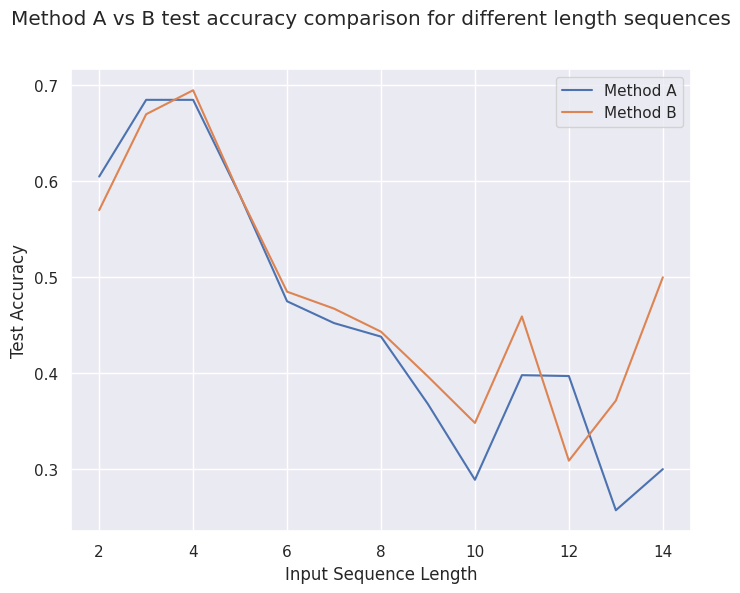

In [95]:
plt.figure(figsize=(8, 6))

x, y = eval_different_length_test(simple_GRU_A, max_len=14)
axA = sns.lineplot(x=x, y=y, label="Method A")

x, y = eval_different_length_test(simple_GRU_B, max_len=14)
axB = sns.lineplot(x=x, y=y, label="Method B")

# plt.legend(["Method A", "Method B"])
plt.legend()
plt.ylabel("Test Accuracy")
plt.xlabel("Input Sequence Length")
plt.suptitle("Method A vs B test accuracy comparison for different length sequences")

plt.show()

In [96]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU_A, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a brushstroke on the canvas of your journey to
radiate some for it carries the echoes of your soul on the
believe that this morning let gratitude fill your lungs and heart reminding
life 's actual purpose is a treasure trove that brightens someone 's day leaving a
dance through each and every step we take towards our dreams and aspirations and weave
let your time and energy joy wherever you go in the heart spreading warmth and
every person is a leap of faith is a beacon of light for
our country Singapore is a sanctuary of innovation sparks and ideas take flight flight
planet earth is rich with the strokes of our planet 's future aspirations
morning and evening would make it with the world of compassion letting kindness be your legacy


In [97]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU_B, seed_text, next_words=10)
    print(predicted_text)

embrace each day leaving a trail of smiles and warmth and appreciation to
radiate some and let it be the foundation of your legacy of
believe that propels you forward kindness a beacon of hope for our
life 's actual purpose is an investment in your future success your success be the
dance through each and every step is a leap of faith for they carry the
let your time and energy singapore 's energy is palpable palpable palpable boundless power of
every person is a reminder of the cycles of life on our planet
our country Singapore is limitless journey a beacon of hope for our planet 's
planet earth is boundless promise of new beginnings reminding us of the preciousness
morning and evening would make it with strength and wisdom will be a force of nature


* Both methods are comparable in their final results, however method B seems to improve much faster than method A.
* The comparison for test accuracy of sequences of different lengths shows that method B generally performs better.
* Both methods plateau at around 0.47 validation accuracy, while there is an inflection point where validation loss begins to increase for both.

Some sequences of words repeated in the dataset can be followed by various different words, which may be part of the reason why the probability is high for a large number of words.

In [98]:
X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=0)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=0)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=0)

## SimpleRNN (Recurrent Neural Network) vs GRU (Gated Recurrent Unit) vs LSTM (Long Short-Term Memory)

In [118]:
basic_RNNs = {}

In [119]:
simple_RNN = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    SimpleRNN(64),
    Dense(total_words, activation='softmax')
])
simple_RNN.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=1,
    min_delta=0.005,
    mode="max",
    restore_best_weights=True
)

basic_RNNs["SimpleRNN"] = fit_model(simple_RNN, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 12s 77ms/step - loss: 5.5333 - accuracy: 0.1143 - val_loss: 5.3000 - val_accuracy: 0.1477
Epoch 2/50
150/150 [==============================] - 9s 63ms/step - loss: 4.4727 - accuracy: 0.2100 - val_loss: 4.5014 - val_accuracy: 0.2801
Epoch 3/50
150/150 [==============================] - 10s 65ms/step - loss: 3.5582 - accuracy: 0.3426 - val_loss: 4.0615 - val_accuracy: 0.3296
Epoch 4/50
150/150 [==============================] - 9s 62ms/step - loss: 2.8741 - accuracy: 0.4372 - val_loss: 3.8418 - val_accuracy: 0.3773
Epoch 5/50
150/150 [==============================] - 9s 62ms/step - loss: 2.3566 - accuracy: 0.5216 - val_loss: 3.7229 - val_accuracy: 0.3989
Epoch 6/50
150/150 [==============================] - 10s 65ms/step - loss: 1.9603 - accuracy: 0.5949 - val_loss: 3.6527 - val_accuracy: 0.4110
Epoch 7/50
150/150 [==============================] - 9s 61ms/step - loss: 1.6492 - accuracy: 0.6524 - val_loss: 3.6078 - val_accuracy: 0.4

In [120]:
simple_RNN.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_17 (Embedding)    (None, 40, 768)           907008    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                53312     
                                                                 
 dense_17 (Dense)            (None, 1181)              76765     
                                                                 
Total params: 1037085 (3.96 MB)
Trainable params: 1037085 (3.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [121]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day filled with endless possibilities it brings light to even the
radiate some and let it be the foundation of your success be
believe that purpose you stand tall a testament to the nation 's
life 's actual purpose is a step towards a contented heart this morning find the
dance through each and every day is a gift a reminder of the marvel of
let your time and energy is a treasure trove of nature heart 's deepest desires
every person is its strength and wisdom it is the heartbeat of humanity
our country Singapore is a gift from the universe a reminder of the marvel
planet earth is its strength and fortitude to overcome any obstacle that comes
morning and evening would make it is a step towards excellence and progress and vision of


In [122]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=1,
    min_delta=0.005,
    mode="max",
    restore_best_weights=True
)

basic_RNNs["GRU"] = fit_model(simple_GRU, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 8s 41ms/step - loss: 5.5920 - accuracy: 0.1171 - val_loss: 5.4801 - val_accuracy: 0.1386
Epoch 2/50
150/150 [==============================] - 3s 18ms/step - loss: 4.6456 - accuracy: 0.1887 - val_loss: 4.6482 - val_accuracy: 0.2392
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 3.6163 - accuracy: 0.3356 - val_loss: 4.1859 - val_accuracy: 0.3200
Epoch 4/50
150/150 [==============================] - 2s 14ms/step - loss: 2.9824 - accuracy: 0.4124 - val_loss: 3.9838 - val_accuracy: 0.3450
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 2.5667 - accuracy: 0.4580 - val_loss: 3.8756 - val_accuracy: 0.3604
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 2.2512 - accuracy: 0.5058 - val_loss: 3.8020 - val_accuracy: 0.3686
Epoch 7/50
150/150 [==============================] - 2s 13ms/step - loss: 1.9967 - accuracy: 0.5502 - val_loss: 3.7600 - val_accuracy: 0.3855

In [123]:
simple_GRU.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_18 (Embedding)    (None, 40, 768)           907008    
                                                                 
 gru_10 (GRU)                (None, 64)                160128    
                                                                 
 dense_18 (Dense)            (None, 1181)              76765     
                                                                 
Total params: 1143901 (4.36 MB)
Trainable params: 1143901 (4.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(64),
    Dense(total_words, activation='softmax')
])
simple_LSTM.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=1,
    min_delta=0.005,
    mode="max",
    restore_best_weights=True
)

basic_RNNs["LSTM"] = fit_model(simple_LSTM, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 8s 40ms/step - loss: 5.6617 - accuracy: 0.0810 - val_loss: 5.6090 - val_accuracy: 0.0866
Epoch 2/50
150/150 [==============================] - 3s 19ms/step - loss: 5.0352 - accuracy: 0.0977 - val_loss: 5.2629 - val_accuracy: 0.0914
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 4.6112 - accuracy: 0.1669 - val_loss: 4.8819 - val_accuracy: 0.1954
Epoch 4/50
150/150 [==============================] - 2s 13ms/step - loss: 4.1040 - accuracy: 0.2570 - val_loss: 4.5310 - val_accuracy: 0.2806
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 3.6611 - accuracy: 0.3368 - val_loss: 4.3249 - val_accuracy: 0.3080
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 3.3027 - accuracy: 0.3760 - val_loss: 4.1801 - val_accuracy: 0.3248
Epoch 7/50
150/150 [==============================] - 2s 13ms/step - loss: 2.9990 - accuracy: 0.4068 - val_loss: 4.0835 - val_accuracy: 0.3325

In [125]:
simple_LSTM.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_19 (Embedding)    (None, 40, 768)           907008    
                                                                 
 lstm_1 (LSTM)               (None, 64)                213248    
                                                                 
 dense_19 (Dense)            (None, 1181)              76765     
                                                                 
Total params: 1197021 (4.57 MB)
Trainable params: 1197021 (4.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


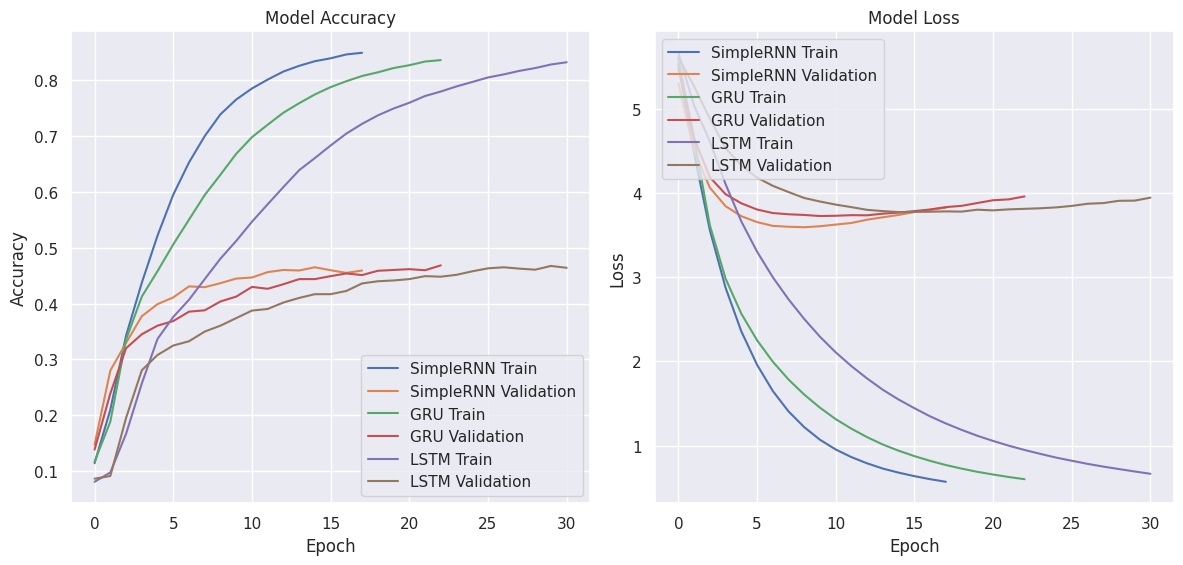

In [126]:
plot_history(basic_RNNs, "")

* SimpleRNN, LSTM, and GRU can all achieve roughly the same accuracy.
* All of the models start overfitting quickly.
* GRU is the fastest to train followed by LSTM then SimpleRNN in terms of time
* All of the models have an increasing loss over time.
* Both LSTM and GRU could work for this application so I may explore both.

## Model Improvement
* Increasing model complexity (Number of units, number of layers)
* Bidirectional
* Attention Mechanism
* n-gram Text Vectorization

In [129]:
more_RNNs = {}

simple_GRU_128 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(128),
    Dense(total_words, activation='softmax')
])
simple_GRU_128.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=1,
    min_delta=0.002,
    mode="max",
    restore_best_weights=True
)

more_RNNs["GRU_128"] = fit_model(simple_GRU_128, "", batch_size=256, epochs=50, callbacks=[early_stopping])

simple_GRU_128_2 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(128, return_sequences=True),
    GRU(128),
    Dense(total_words, activation='softmax')
])
simple_GRU_128_2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=1,
    min_delta=0.002,
    mode="max",
    restore_best_weights=True
)

more_RNNs["GRU_128_2"] = fit_model(simple_GRU_128_2, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 7s 38ms/step - loss: 5.3308 - accuracy: 0.1445 - val_loss: 4.9031 - val_accuracy: 0.2324
Epoch 2/50
150/150 [==============================] - 3s 18ms/step - loss: 3.6388 - accuracy: 0.3331 - val_loss: 4.0877 - val_accuracy: 0.3383
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 2.6551 - accuracy: 0.4487 - val_loss: 3.8217 - val_accuracy: 0.3816
Epoch 4/50
150/150 [==============================] - 2s 14ms/step - loss: 2.0087 - accuracy: 0.5607 - val_loss: 3.7071 - val_accuracy: 0.4134
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 1.5472 - accuracy: 0.6489 - val_loss: 3.6610 - val_accuracy: 0.4230
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 1.2192 - accuracy: 0.7186 - val_loss: 3.6271 - val_accuracy: 0.4466
Epoch 7/50
150/150 [==============================] - 2s 13ms/step - loss: 0.9843 - accuracy: 0.7676 - val_loss: 3.6380 - val_accuracy: 0.4567

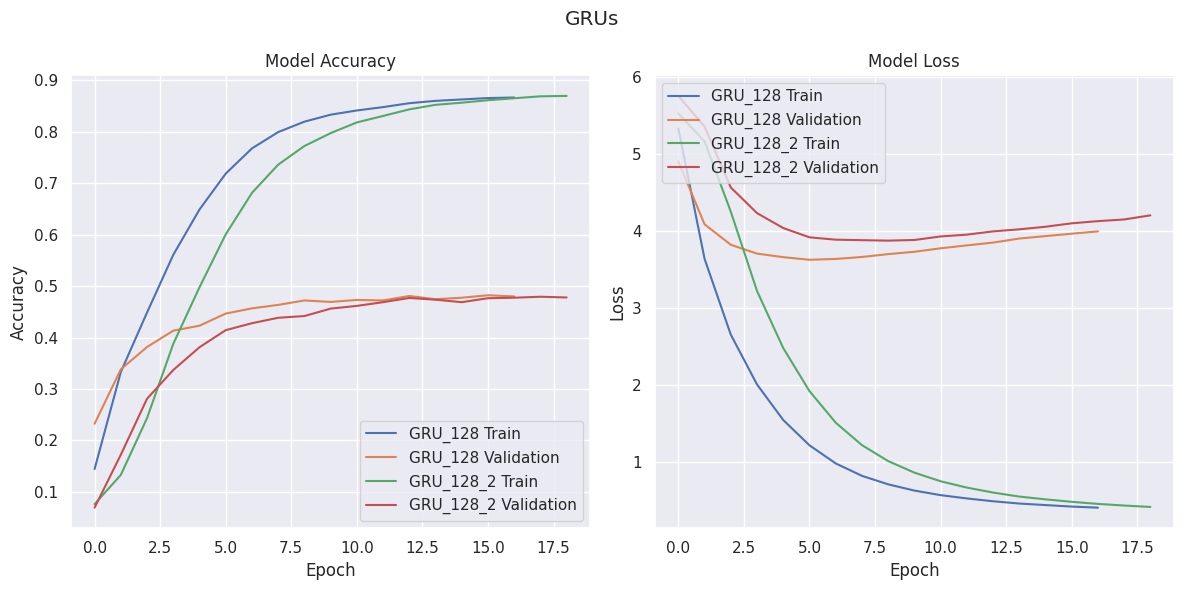

In [130]:
plot_history(more_RNNs, "GRUs")

No benefit to using 2 layers since the data is already not very complex.

In [139]:
more_RNNs = {"GRU_128": more_RNNs["GRU_128"]}

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=2,
    min_delta=0,
    mode="max",
    restore_best_weights=True
)

simple_GRU_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(256),
    Dense(total_words, activation='softmax')
])
simple_GRU_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_256"] = fit_model(simple_GRU_256, "", batch_size=256, epochs=50, callbacks=[early_stopping])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_512"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

simple_GRU_1024 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(1024),
    Dense(total_words, activation='softmax')
])
simple_GRU_1024.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_1024"] = fit_model(simple_GRU_1024, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 7s 35ms/step - loss: 4.8823 - accuracy: 0.2032 - val_loss: 4.3351 - val_accuracy: 0.3051
Epoch 2/50
150/150 [==============================] - 3s 22ms/step - loss: 2.7176 - accuracy: 0.4458 - val_loss: 3.7390 - val_accuracy: 0.3999
Epoch 3/50
150/150 [==============================] - 2s 15ms/step - loss: 1.6134 - accuracy: 0.6386 - val_loss: 3.5711 - val_accuracy: 0.4432
Epoch 4/50
150/150 [==============================] - 2s 14ms/step - loss: 1.0243 - accuracy: 0.7585 - val_loss: 3.5540 - val_accuracy: 0.4634
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 0.7328 - accuracy: 0.8142 - val_loss: 3.5865 - val_accuracy: 0.4812
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 0.5871 - accuracy: 0.8381 - val_loss: 3.6156 - val_accuracy: 0.4937
Epoch 7/50
150/150 [==============================] - 2s 13ms/step - loss: 0.5018 - accuracy: 0.8542 - val_loss: 3.6632 - val_accuracy: 0.5072

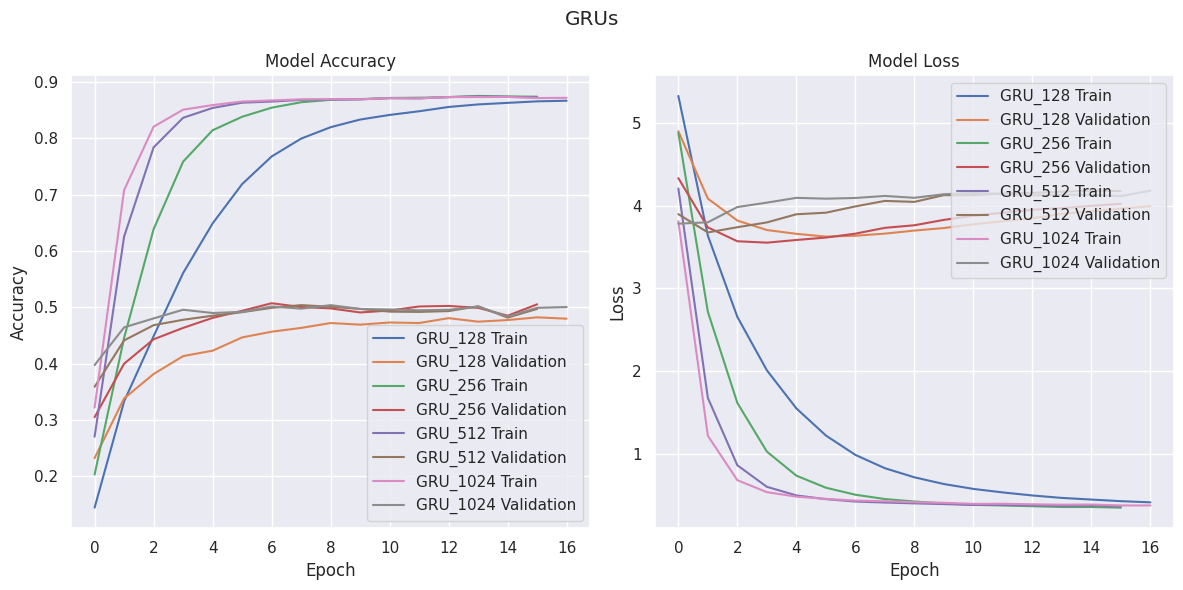

In [140]:
plot_history(more_RNNs, "GRUs")

Both 256 and 512 are able to capture the information well.

In [ ]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=40,
    ngrams=4
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

In [141]:
ngram_RNNs = {"1-gram": more_RNNs["GRU_512"]}

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=2,
    min_delta=0,
    mode="max",
    restore_best_weights=True
)

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["2-gram"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=3
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["3-gram"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=4
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["4-gram"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 12s 59ms/step - loss: 4.5579 - accuracy: 0.2361 - val_loss: 4.0987 - val_accuracy: 0.3720
Epoch 2/50
150/150 [==============================] - 5s 35ms/step - loss: 2.3421 - accuracy: 0.5002 - val_loss: 3.9006 - val_accuracy: 0.4379
Epoch 3/50
150/150 [==============================] - 4s 25ms/step - loss: 1.5133 - accuracy: 0.6254 - val_loss: 4.0659 - val_accuracy: 0.4678
Epoch 4/50
150/150 [==============================] - 3s 21ms/step - loss: 1.1180 - accuracy: 0.7012 - val_loss: 4.1636 - val_accuracy: 0.4644
Epoch 5/50
150/150 [==============================] - 3s 20ms/step - loss: 0.9070 - accuracy: 0.7433 - val_loss: 4.2981 - val_accuracy: 0.4692
Epoch 6/50
150/150 [==============================] - 3s 21ms/step - loss: 0.7871 - accuracy: 0.7700 - val_loss: 4.3810 - val_accuracy: 0.4740
Epoch 7/50
150/150 [==============================] - 3s 20ms/step - loss: 0.7061 - accuracy: 0.7879 - val_loss: 4.4610 - val_accuracy: 0.483

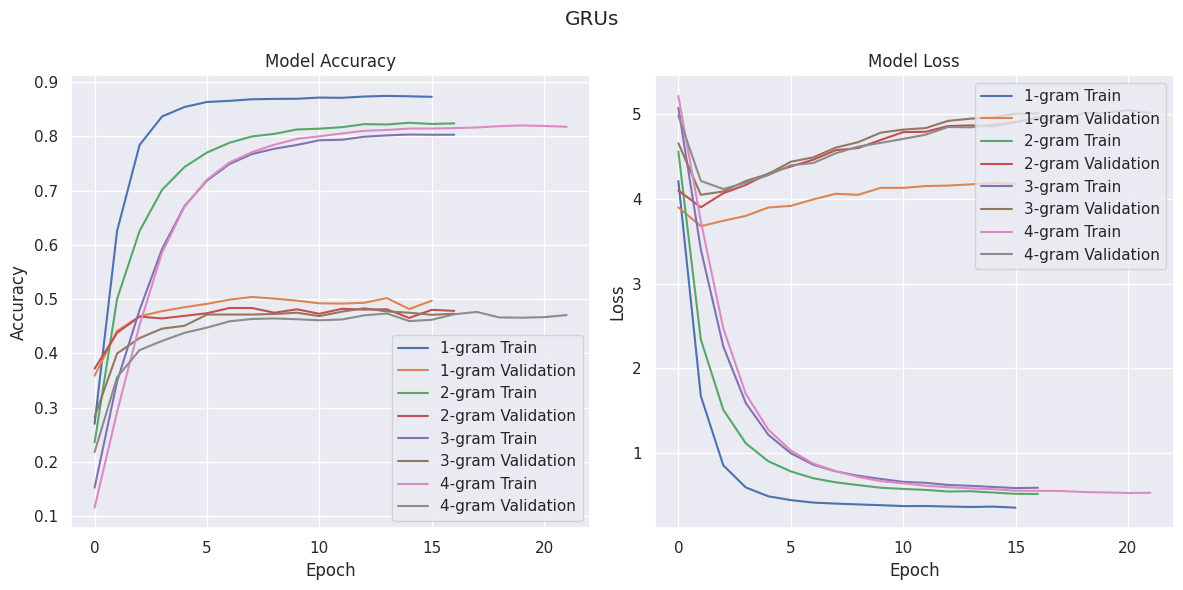

In [142]:
plot_history(ngram_RNNs, "GRUs")

In [143]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU_512, seed_text, next_words=10)
    print(predicted_text)

embrace each day can hearts together together together together together together together together
radiate some for it is the language of love without words words
believe that falls is a lesson to be embraced embraced embraced embraced
life 's actual purpose is a testament to the strength and resilience the strength hope
dance through each and every of into life bloom bloom bloom a path towards bloom
let your time and energy be your source of inspiration inspiration inspiration inspiration inspiration inspiration
every person is a chance for adventure the path to your aspirations and
our country Singapore is its gardens singapore 's nature is a treasure trove trove
planet earth is its to souls souls souls souls souls souls souls souls
morning and evening would make it is built bloom bloom bloom to souls souls souls souls


In [160]:
vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

vectorize_layer("embrace each day can hearts")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  25,  182,  134,  245,  121,    1, 1376,    1,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

* Since the dataset is small, there are many n-grams that will not appear in the dataset. Thus they will be set to `1` which skews the results. 
* The result of the n-gram encoding also performs much worse than 1-gram. Thus I will not use n-gram text vectorization.

In [ ]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    GRU(200, return_sequences=True),
    GRU(200),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_GRU, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

In [316]:
simple_stacked = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    RNN(StackedRNNCells([LSTMCell(32) for _ in range(2)])),
    # Dense(2000, activation="relu"),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_stacked, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=128, epochs=20)

Epoch 1/20
286/286 [==============================] - 84s 290ms/step - loss: 5.5659 - accuracy: 0.0687 - val_loss: 5.6089 - val_accuracy: 0.0885
Epoch 2/20
286/286 [==============================] - 78s 273ms/step - loss: 5.3031 - accuracy: 0.0726 - val_loss: 5.6810 - val_accuracy: 0.0885
Epoch 3/20
286/286 [==============================] - 77s 269ms/step - loss: 5.3010 - accuracy: 0.0743 - val_loss: 5.7247 - val_accuracy: 0.0628
Epoch 4/20
286/286 [==============================] - 77s 270ms/step - loss: 5.2998 - accuracy: 0.0731 - val_loss: 5.7522 - val_accuracy: 0.0628
Epoch 5/20
286/286 [==============================] - 78s 271ms/step - loss: 5.2989 - accuracy: 0.0727 - val_loss: 5.7772 - val_accuracy: 0.0628
Epoch 6/20
286/286 [==============================] - 79s 276ms/step - loss: 5.2979 - accuracy: 0.0758 - val_loss: 5.7843 - val_accuracy: 0.0885
Epoch 7/20
286/286 [==============================] - 80s 279ms/step - loss: 5.2980 - accuracy: 0.0732 - val_loss: 5.8095 - val_ac

KeyboardInterrupt: 

In [198]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200
)

vectorize_layer.adapt([" ".join(x) for x in tokenized_quotes])

simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 100),
    # Flatten(),
    LSTM(200, return_sequences=True),
    LSTM(200),
    Dense(total_words, activation='softmax')
])


simple_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_LSTM, "training_checkpoints/simple_LSTM_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
 49/241 [=====>........................] - ETA: 57s - loss: 5.6612 - accuracy: 0.0728

KeyboardInterrupt: 

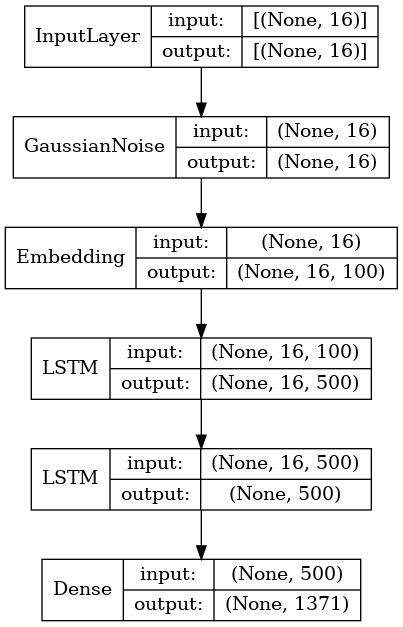

In [117]:
plot_model(simple_RNN, to_file='images/models/simple_LSTM.png', show_shapes=True, show_layer_names=False)

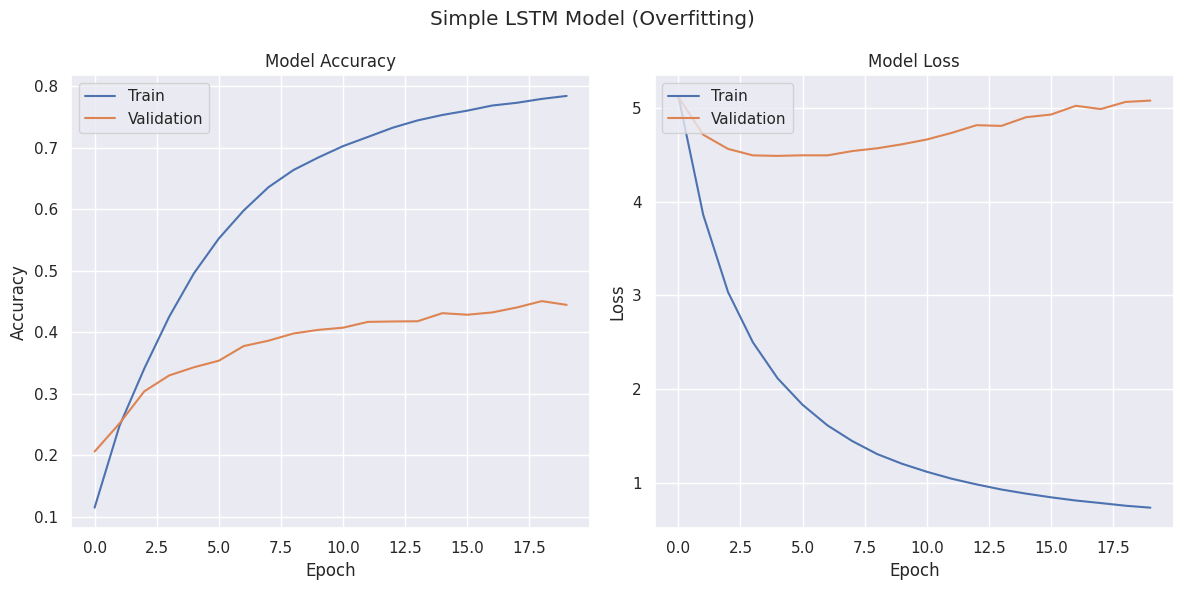

In [104]:
plot_history(history, "Simple LSTM Model (Overfitting)", "images/Simple LSTM Model (Overfitting).png")

* The model is unable to generalise and severely overfits on the training set.

In [45]:
# Attention is all you need

inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=total_words, output_dim=2000)(inputs)
lstm_layer = GRU(200, return_sequences=True)(embedding_layer)

attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
context_vector = tf.reduce_sum(attention * lstm_layer, axis=1)

output = Dense(total_words, activation='softmax')(context_vector)

attention_model = Model(inputs=inputs, outputs=output)

attention_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(attention_model, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 5.6172 - accuracy: 0.0888
Epoch 1: val_loss improved from inf to 5.49605, saving model to training_checkpoints/simple_RNN_weights.01-0.09.hdf5
153/153 [==============================] - 4s 23ms/step - loss: 5.6172 - accuracy: 0.0888 - val_loss: 5.4960 - val_accuracy: 0.0930
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 5.0289 - accuracy: 0.1218
Epoch 2: val_loss improved from 5.49605 to 5.24764, saving model to training_checkpoints/simple_RNN_weights.02-0.14.hdf5
153/153 [==============================] - 2s 12ms/step - loss: 5.0289 - accuracy: 0.1218 - val_loss: 5.2476 - val_accuracy: 0.1417
Epoch 3/50
153/153 [==============================] - ETA: 0s - loss: 4.5129 - accuracy: 0.1549
Epoch 3: val_loss improved from 5.24764 to 5.01739, saving model to training_checkpoints/simple_RNN_weights.03-0.18.hdf5
153/153 [==============================] - 2s 11ms/step - loss: 4.5129 - accuracy: 0.1549

KeyboardInterrupt: 

In [ ]:
attention_model.summary()

In [276]:
# Build the model
simple_RNN3 = Sequential([
    # GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    Bidirectional(LSTM(50, return_sequences=True)),
    # LSTM(50, return_sequences=True),
    
    Attention(),
    Dropout(0.3),
    Dense(1000),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN3, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

ValueError: Exception encountered when calling layer "attention_3" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 35, 50), dtype=float32).

Call arguments received by layer "attention_3" (type Attention):
  • inputs=tf.Tensor(shape=(None, 35, 50), dtype=float32)
  • mask=None
  • training=None
  • return_attention_scores=False
  • use_causal_mask=False

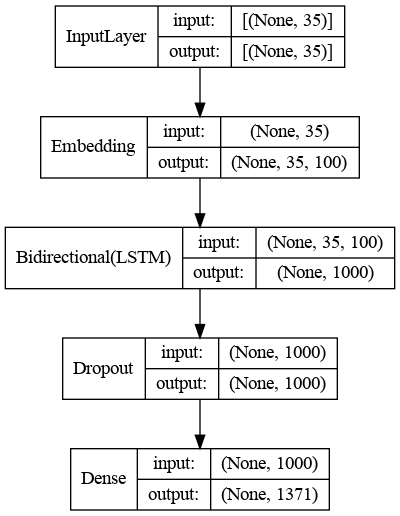

In [260]:
plot_model(simple_RNN3, show_shapes=True, show_layer_names=False)

In [124]:
# Build the model
simple_RNN2 = Sequential([
    GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    LSTM(100),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN2, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=20)

Epoch 1/20
389/389 [==============================] - ETA: 0s - loss: 5.3696 - accuracy: 0.0935
Epoch 1: val_loss improved from inf to 5.39246, saving model to training_checkpoints/simple_RNN_weights.01-0.12.hdf5
389/389 [==============================] - 18s 44ms/step - loss: 5.3696 - accuracy: 0.0935 - val_loss: 5.3925 - val_accuracy: 0.1245
Epoch 2/20
388/389 [============================>.] - ETA: 0s - loss: 4.6576 - accuracy: 0.1743
Epoch 2: val_loss improved from 5.39246 to 4.96396, saving model to training_checkpoints/simple_RNN_weights.02-0.21.hdf5
389/389 [==============================] - 15s 38ms/step - loss: 4.6567 - accuracy: 0.1743 - val_loss: 4.9640 - val_accuracy: 0.2063
Epoch 3/20
388/389 [============================>.] - ETA: 0s - loss: 4.1654 - accuracy: 0.2235
Epoch 3: val_loss improved from 4.96396 to 4.73630, saving model to training_checkpoints/simple_RNN_weights.03-0.25.hdf5
389/389 [==============================] - 13s 35ms/step - loss: 4.1646 - accuracy: 0.2

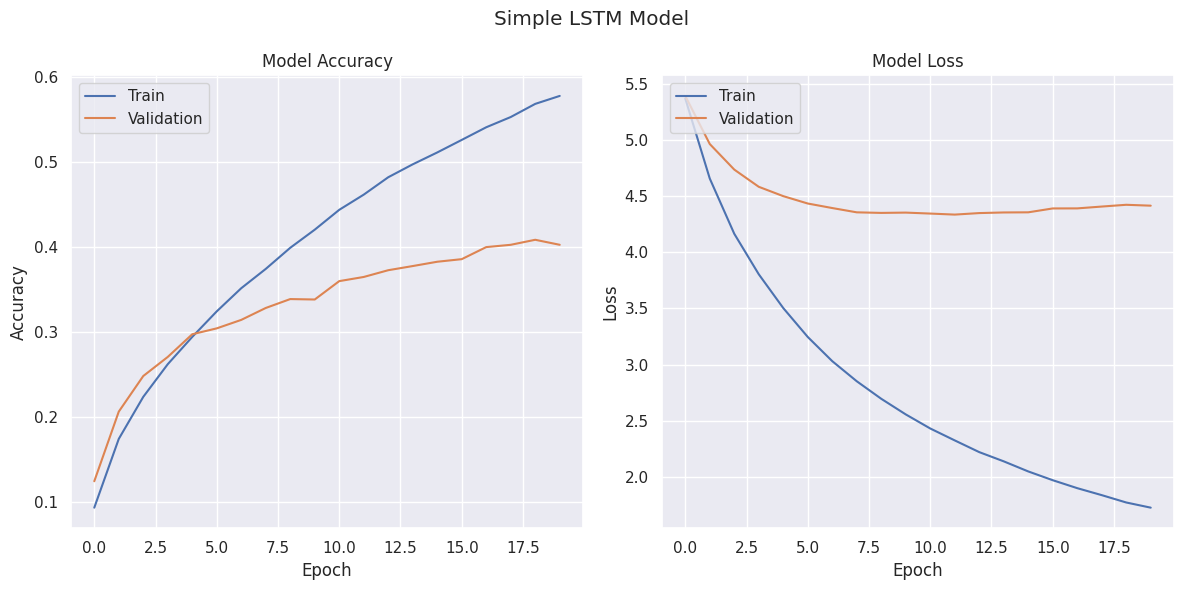

In [125]:
plot_history(history, "Simple LSTM Model")

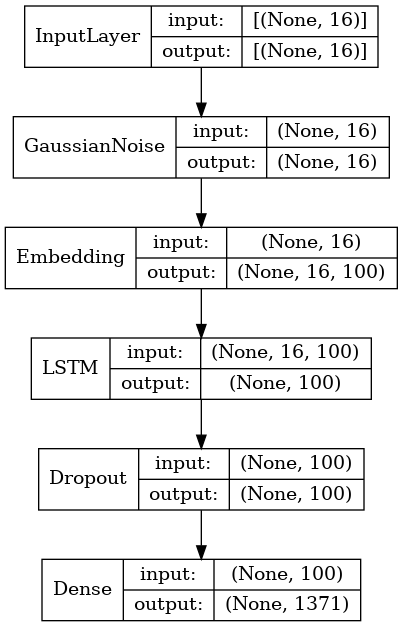

In [126]:
plot_model(simple_RNN2, to_file='images/models/simple_RNN2.png', show_shapes=True, show_layer_names=False)

In [79]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_LSTM, seed_text, next_words=10)
    print(predicted_text)

embrace each day is the of your heart of your heart of your
radiate some the of your heart of your heart of your heart
believe that the of your heart of your heart of your heart
life is actual purpose is the of the of your heart of your heart of
dance through each and every heart of your heart of your heart of your heart
let your time and energy is a of your heart of your heart of the
every person is a is a of the heart of your heart of
our country Singapore is are the are the of your heart of your heart
planet earth is are the of your heart of your heart of your
morning and evening would make it is the of your heart of your heart of your


In [391]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(attention_model, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for it paint with vibrant heart with
radiate some for it is the heartbeat of your life well lived
believe that yourself for it is the spark that forward forward transformation
life 's actual purpose is a bridge that connects hearts to your future for others
dance through each and every savoring a joyful one one one gift that its time
let your time and energy the ripple that cuts creates doubt connections sun sun meet
every person is a has a power to the world of life 's
our country Singapore is a precious set that words and let go go of
planet earth is the precious heartbeat of our life 's gardens embrace from
morning and evening would make it has the potential to make a difference holds the magic


In [389]:
print("hello")

hello


In [159]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for new beginnings and fresh opportunities and
radiate some for it is the key to unlocking a bright future
believe that cuts through fear brings your way to success knows no
life 's actual purpose is a step towards miracles the extraordinary moments that defy logic
dance through each and every to navigate your path with purpose and determination shape destinies
let your time and energy flourish hold the keys to your potential and possibility your
every person is marine species protect the treasures of our planet 's future
our country Singapore is a treasure trove singapore 's nature is a sanctuary to
planet earth is a gateway to a brighter future in the realization of
morning and evening would make it 's journey and adventures to the soul from the chains


In [ ]:
# funny preprocessing

In [89]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day unveil the brilliance of you of the universe a reminder
radiate some lion city kindness defines the community for it is the
believe that you are capable of greatness for they hold the hues
life is actual purpose is biodiversity to jurong lake gardens serenity singapore is nature is
dance through each and every step is a leap of faith this morning find the
let your time and energy with warmth and appreciation a reminder that you are capable
every person is tranquility is a treasure trove of gratitude and watch how
our country Singapore is song is a celebration of every step we take forward
planet earth is ambition and embraces diversity is its strength and strength and
morning and evening would make it is rich with the fruits of love and joy a


In [ ]:
## normal preprocessing

In [94]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day with the seeds of your heart be the way for
radiate some it is the heartbeat of your heart be the way
believe that this morning find the beauty of the world of this
life is actual purpose is a testament to the beauty of the world of this
dance through each and every it is the heartbeat of your heart be the way
let your time and energy is a testament to the beauty of the world of
every person is a testament to the beauty of the world of this
our country Singapore is savannas are the seeds of your heart be the way
planet earth is forests are the seeds of your heart be the way
morning and evening would make it is the heartbeat of your heart be the way for
